In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import scipy
import scanpy as sc
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csgraph
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import umap
from sklearn import linear_model
from matplotlib.lines import Line2D
from collections import Counter
import sklearn
import scipy.stats as sps
from scipy.spatial.distance import cdist
from importlib import reload
import mygene

import gget
import sys

# locals
sys.path.append("../")
import utils as ut
import continuum as cont
reload(ut)
reload(cont)

2023-06-20 10:01:18.677692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 10:01:27.712486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-20 10:01:27.712542: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-20 10:01:28.669644: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-20 10:01:45.189200: W tensorflow/stream_executor/pla

<module 'continuum' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/continuum/continuum.py'>

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
xy['metaTypes'] = xy['cellTypes']
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors', 'metaTypes']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
HFD8...
HFD14...
done


In [3]:
# load the macspectrum data
macDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/macSpectrum/macspectrumData/GSE117176_RAW/"
min_genes = 100
min_cells = 10

msData = {}

for mkey in os.listdir(macDir):
    mtxPath = f"{macDir}{mkey}"
    
    data = sc.read_10x_mtx(mtxPath, 
                           # var_names='gene_symbols', 
                           cache=True)
    
    data.var_names = [x.upper() for x in data.var_names] # uppercase gene names
    sc.pp.filter_cells(data, min_genes=min_genes)
    sc.pp.filter_genes(data, min_cells=min_cells)
    sc.pp.normalize_total(data, target_sum=1e6) 
    
    df = data.to_df()
    df = df.loc[:,~df.columns.duplicated()].copy() # drop duplicate column names
    msData[mkey] = df
    print(mkey, df.shape)

print('done')

lnATM (1706, 12244)
M2 (6391, 12819)
M1 (4736, 12178)
obATM (1758, 11915)
M0 (6979, 12915)
done


In [4]:
# get common genes
allGenes = [] 

for key in keys:
    rf = rna[key]
    allGenes += rf.columns.to_list()
    
for mkey, mf in msData.items():
    allGenes += mf.columns.to_list()
    
gf = pd.DataFrame(allGenes, columns=['gene'])
gf = pd.DataFrame(gf.groupby('gene')['gene'].count())
gf.columns = ['count']
gf = gf.reset_index(drop=False)

t = 8

exGene = gf[gf['count'] > (t-1)]
print(exGene.shape)
geneList = exGene['gene'].to_list()
print(f"{len(geneList)=}")
exGene.head()

(10356, 2)
len(geneList)=10356


gene  count
3   0610009B22RIK      8
5   0610009O20RIK      8
6   0610010F05RIK      8
7   0610010K14RIK      8
10  0610012G03RIK      8

# M1-M2 Polarization

In [5]:
p1 = msData['M1'][geneList]
p2 = msData['M2'][geneList]
deg = cont.getDEGs(p1, p2)

alpha = 0.01
n = 100 # number of genes
p = None # constraint on the number cells expressing the gene

corrGenes, sig = cont.getSignificant(deg, alpha, n, p, method='log2foldchange')
print(f"{sig.shape=}")

alpha=0.01 ntests=10356 9.704838718205266e-07
sig.shape=(100, 9)


In [6]:
macTypes = ['Mac1','Mac2','Mac3','Mac4','Mac5',]

res = []

normalize = True
log = True
metric = 'correlation'

# build the signature of the poles
meanP1 = cont.getSignature(p1, corrGenes, norm=normalize, log=log)
meanP2 = cont.getSignature(p2, corrGenes, norm=normalize, log=log)

print(f"{meanP1.shape=} {meanP2.shape=}")


for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # get correlations to cell type
    rf = rf[corrGenes]
    rf = rf.fillna(0)
    
    if log:
        rf = np.log1p(rf)
    
    if normalize:
        rf[corrGenes] = sklearn.preprocessing.minmax_scale(rf[corrGenes], 
                                                           feature_range=(0, 1), axis=1)
        
    p1Dist = scipy.spatial.distance.cdist(rf, meanP1, metric)
    p2Dist = scipy.spatial.distance.cdist(rf, meanP2, metric)
    
    # normalize distance to range (0, 1)
    p1Dist = sklearn.preprocessing.minmax_scale(p1Dist, feature_range=(0, 1))
    p2Dist = sklearn.preprocessing.minmax_scale(p2Dist, feature_range=(0, 1))
    
    pred = pd.DataFrame({
        'p1' : p1Dist.ravel(),
        'p2' : p2Dist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)

res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()


meanP1.shape=(1, 100) meanP2.shape=(1, 100)
res.shape=(6431, 8)


p1        p2              cellId key cellType         x         y   
0  0.771487  0.292355  AAAGAACGTCTACAGT.1  ND     Mac1  3.089298 -1.726030  \
1  0.797236  0.115087  AAAGAACTCCTCGCAT.1  ND     Mac1  3.614130 -1.571004   
2  0.712014  0.477793  AAAGGGCGTTAGGGTG.1  ND     Mac3  3.086352  6.166065   
3  0.764233  0.358437  AACAAAGCACCGGCTA.1  ND     Mac3  4.344001  5.801922   
4  0.860258  0.113212  AACAAAGGTTCACGAT.1  ND     Mac1  0.130051 -1.583494   

     metaTypes  
0  Macrophages  
1  Macrophages  
2  Macrophages  
3  Macrophages  
4  Macrophages

In [7]:
# break

x = p1, y = p2
0.7044x + y + -0.9184 = 0


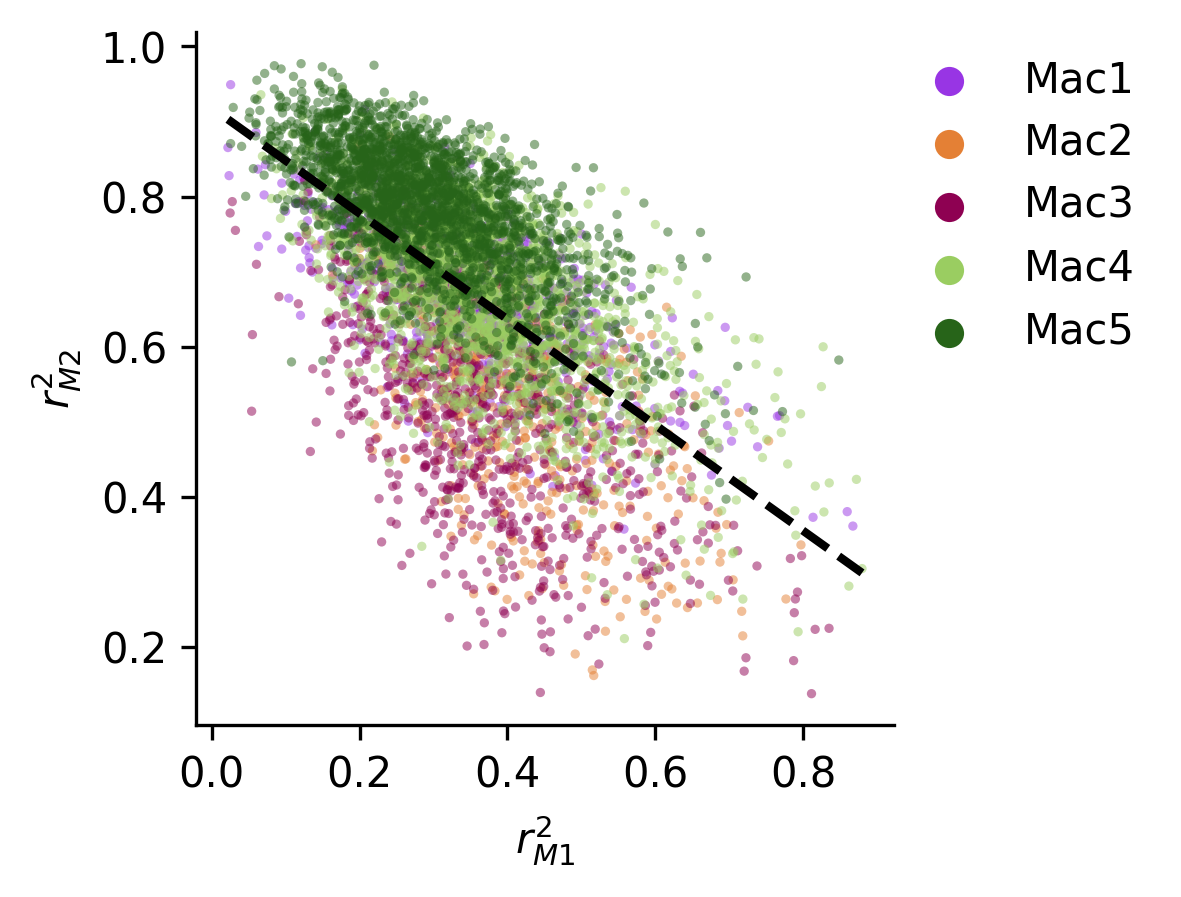

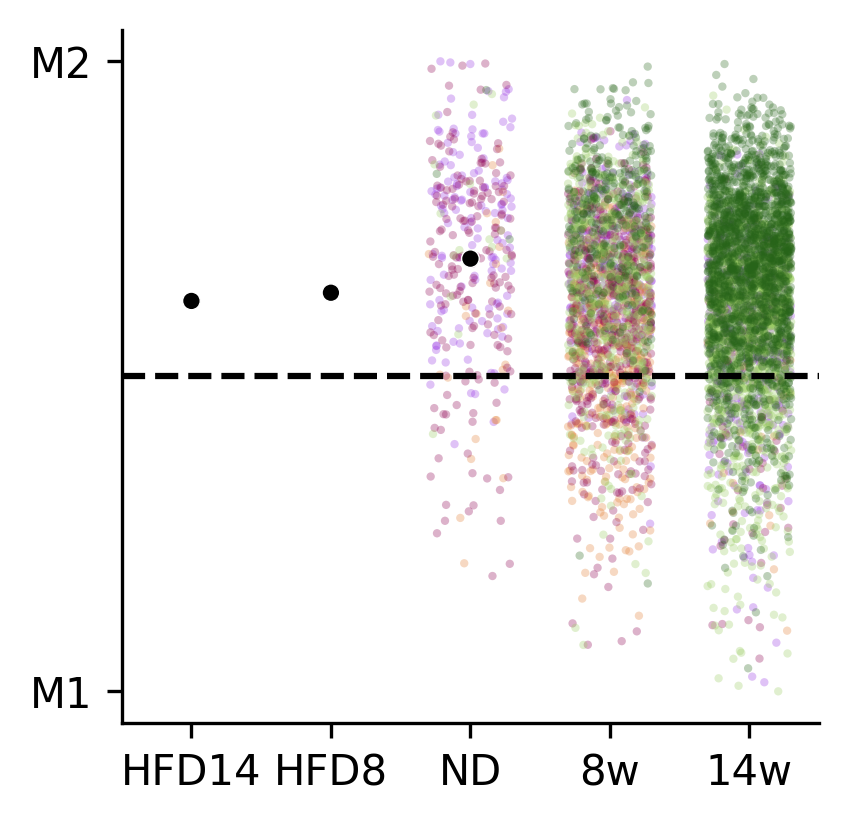

In [8]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

# remove outliers before fitting models
lb = 0.001
ub = 0.999
pdf = cont.filterPoints(pdf, lb, ub)

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)


# get linear projection
pdf = cont.getProjection(pdf)

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=pdf, 
                x='p1',
                y='p2',
                hue='cellType',
                palette=colors,
                s=5,
                alpha=0.5,
                ec='None')

sns.lineplot(data=pdf,
             x='p1',
             y='fit',
             ls="--",
             lw=2,
             color='k')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1.015),
                frameon=False,
                title="")

plt.ylabel(r"$r^2_{M2}$")
plt.xlabel(r"$r^2_{M1}$")

plt.show()

plt.show()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

means = pdf.groupby('key')['dists'].mean().reset_index(drop=False)

sns.scatterplot(data=means, 
                x='key',
                y='dists',
                size=10,
                color='k',
                zorder=5)

sns.stripplot(data=pdf, 
                y='dists',
                x='keyName',
                hue='cellType',
                jitter=0.3,
                s=2,
                palette=colors,
                alpha=0.3)

plt.axhline(y = 0.5, c='k', ls='--', zorder=3)
sns.despine()
plt.gca().legend().remove()


plt.xlabel("")
plt.ylabel("")
plt.yticks([pdf['dists'].min(), pdf['dists'].max()], ['M2', 'M1'])
plt.gca().invert_yaxis()

plt.show()

In [11]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "m1_m2_macspectrum.csv"
pdf.to_csv(f"{dirpath}{fname}", index=False)
pdf.head()

p1        p2              cellId key cellType         x         y   
0  0.228513  0.707645  AAAGAACGTCTACAGT.1  ND     Mac1  3.089298 -1.726030  \
1  0.202764  0.884913  AAAGAACTCCTCGCAT.1  ND     Mac1  3.614130 -1.571004   
2  0.139742  0.886788  AACAAAGGTTCACGAT.1  ND     Mac1  0.130051 -1.583494   
3  0.352726  0.535028  AACAGGGAGCTGAAGC.1  ND     Mac1  3.194319 -2.195499   
4  0.474836  0.686290  AAGAACAAGACTCATC.1  ND     Mac1  2.172548  0.995615   

     metaTypes keyName       fit        xp        yp         l  p2_on_fit   
0  Macrophages      ND  0.757454  0.900744  0.970883  1.106209   0.757454  \
1  Macrophages      ND  0.775592  0.540867  0.804061  0.724139   0.775592   
2  Macrophages      ND  0.819985  0.387130  0.907907  0.710055   0.819985   
3  Macrophages      ND  0.669959  1.488058  0.966471  1.610870   0.669959   
4  Macrophages      ND  0.583945  1.525238  0.581624  1.529573   0.583945   

      dists  
0  0.240822  
1  0.210792  
2  0.137294  
3  0.385683  
4  0.528092

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# M0-M2 Polarization

In [12]:
p1 = msData['M0'][geneList]
p2 = msData['M2'][geneList]
deg = cont.getDEGs(p1, p2)

alpha = 0.01
n = 100 # number of genes
p = None # constraint on the number cells expressing the gene

corrGenes, sig = cont.getSignificant(deg, alpha, n, p, method='log2foldchange')
print(f"{sig.shape=}")

alpha=0.01 ntests=10356 9.704838718205266e-07
sig.shape=(100, 9)


In [13]:
macTypes = ['Mac1','Mac2','Mac3','Mac4','Mac5',]

res = []

normalize = True
log = True
metric = 'correlation'

# build the signature of the poles
meanP1 = cont.getSignature(p1, corrGenes, norm=normalize, log=log)
meanP2 = cont.getSignature(p2, corrGenes, norm=normalize, log=log)

print(f"{meanP1.shape=} {meanP2.shape=}")

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # get correlations to cell type
    rf = rf[corrGenes]
    rf = rf.fillna(0)
    
    if log:
        rf = np.log1p(rf)
    
    if normalize:
        rf[corrGenes] = sklearn.preprocessing.minmax_scale(rf[corrGenes], 
                                                           feature_range=(0, 1), axis=1)
        
    p1Dist = scipy.spatial.distance.cdist(rf, meanP1, metric)
    p2Dist = scipy.spatial.distance.cdist(rf, meanP2, metric)
    
    # normalize distance to range (0, 1)
    p1Dist = sklearn.preprocessing.minmax_scale(p1Dist, feature_range=(0, 1))
    p2Dist = sklearn.preprocessing.minmax_scale(p2Dist, feature_range=(0, 1))
    
    pred = pd.DataFrame({
        'p1' : p1Dist.ravel(),
        'p2' : p2Dist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)

res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()


meanP1.shape=(1, 100) meanP2.shape=(1, 100)
res.shape=(6431, 8)


p1        p2              cellId key cellType         x         y   
0  0.303837  0.635365  AAAGAACGTCTACAGT.1  ND     Mac1  3.089298 -1.726030  \
1  0.419365  0.445858  AAAGAACTCCTCGCAT.1  ND     Mac1  3.614130 -1.571004   
2  0.548920  0.487633  AAAGGGCGTTAGGGTG.1  ND     Mac3  3.086352  6.166065   
3  0.523082  0.122151  AACAAAGCACCGGCTA.1  ND     Mac3  4.344001  5.801922   
4  0.339220  0.672467  AACAAAGGTTCACGAT.1  ND     Mac1  0.130051 -1.583494   

     metaTypes  
0  Macrophages  
1  Macrophages  
2  Macrophages  
3  Macrophages  
4  Macrophages

x = p1, y = p2
0.3411x + y + -0.6977 = 0


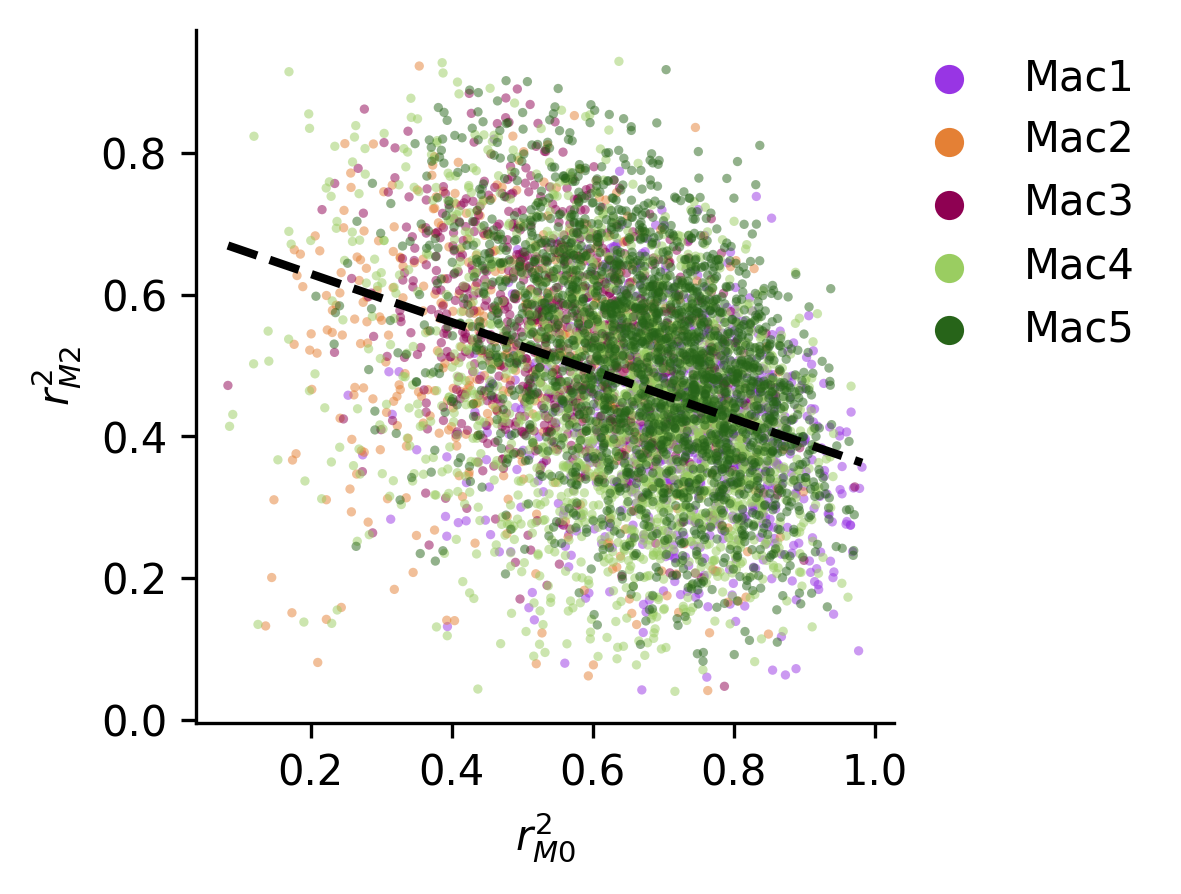

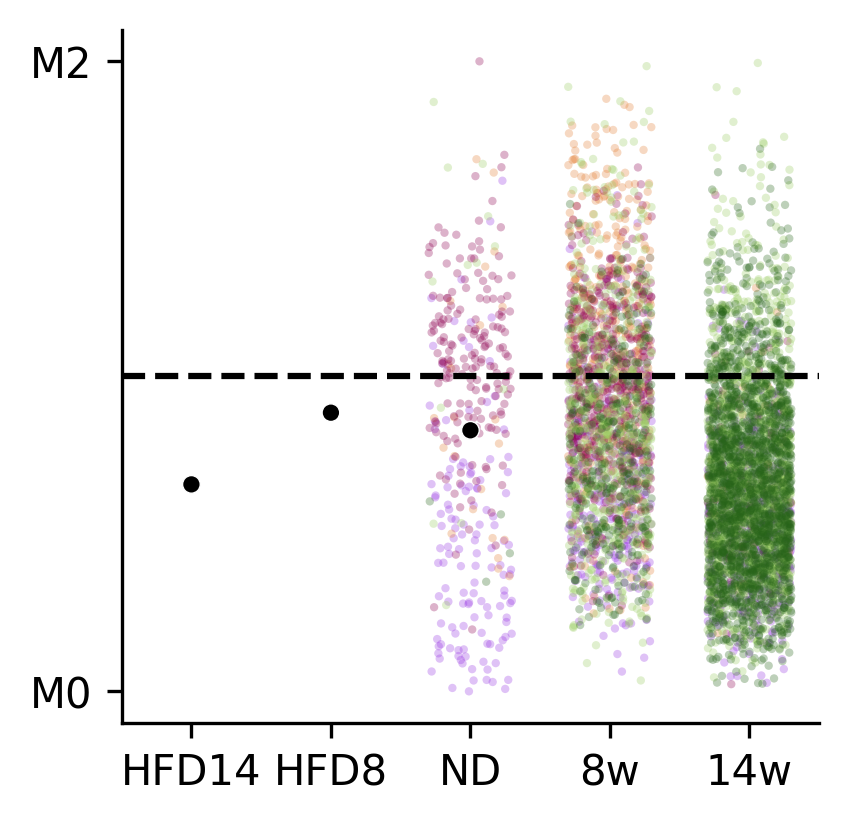

In [14]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

# remove outliers before fitting models
lb = 0.001
ub = 0.999
pdf = cont.filterPoints(pdf, lb, ub)

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)


# get linear projection
pdf = cont.getProjection(pdf)

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=pdf, 
                x='p1',
                y='p2',
                hue='cellType',
                palette=colors,
                s=5,
                alpha=0.5,
                ec='None')

sns.lineplot(data=pdf,
             x='p1',
             y='fit',
             ls="--",
             lw=2,
             color='k')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1.015),
                frameon=False,
                title="")

plt.ylabel(r"$r^2_{M2}$")
plt.xlabel(r"$r^2_{M0}$")

plt.show()

plt.show()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

means = pdf.groupby('key')['dists'].mean().reset_index(drop=False)

sns.scatterplot(data=means, 
                x='key',
                y='dists',
                size=10,
                color='k',
                zorder=5)

sns.stripplot(data=pdf, 
                y='dists',
                x='keyName',
                hue='cellType',
                jitter=0.3,
                s=2,
                palette=colors,
                alpha=0.3)

plt.axhline(y = 0.5, c='k', ls='--', zorder=3)
sns.despine()
plt.gca().legend().remove()


plt.xlabel("")
plt.ylabel("")
plt.yticks([pdf['dists'].min(), pdf['dists'].max()], ['M2', 'M0'])
plt.gca().invert_yaxis()

plt.show()

In [15]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "m0_m2_macspectrum.csv"
pdf.to_csv(f"{dirpath}{fname}", index=False)
pdf.head()

p1        p2              cellId key cellType         x         y   
0  0.696163  0.364635  AAAGAACGTCTACAGT.1  ND     Mac1  3.089298 -1.726030  \
1  0.580635  0.554142  AAAGAACTCCTCGCAT.1  ND     Mac1  3.614130 -1.571004   
2  0.660780  0.327533  AACAAAGGTTCACGAT.1  ND     Mac1  0.130051 -1.583494   
3  0.808445  0.377919  AAGAACAAGACTCATC.1  ND     Mac1  2.172548  0.995615   
4  0.802781  0.138905  AAGACTCAGCTCCATA.1  ND     Mac1  2.935610 -1.643824   

     metaTypes keyName       fit         xp        yp          l  p2_on_fit   
0  Macrophages      ND  0.460292  14.297461  7.377931  15.851544   0.460292  \
1  Macrophages      ND  0.499697  11.116459  7.684401  13.241964   0.499697   
2  Macrophages      ND  0.472360  13.896171  7.667224  15.625829   0.472360   
3  Macrophages      ND  0.421994  16.199912  6.674462  17.309003   0.421994   
4  Macrophages      ND  0.423926  17.539288  7.199522  18.747619   0.423926   

      dists  
0  0.682184  
1  0.553715  
2  0.642837  
3  0.807043  
4  0.800745

In [ ]:
# break

# ATM-LAM Polarization

In [16]:
m1 = cont.getGroup(rna, labels, 'ND', 'Mac1') # pole 1 is ATM
m2 = cont.getGroup(rna, labels, 'ND', 'Mac2') # pole 1 is ATM
m3 = cont.getGroup(rna, labels, 'ND', 'Mac3') # pole 1 is ATM
p1 = pd.concat([m1, m2, m3], ignore_index=True)

p2 = cont.getGroup(rna, labels, 'HFD14', 'Mac5') # pole 2 is LAM
print(f"{p1.shape=} {p2.shape=}")

# get the differnetially expressed genes
deg = cont.getDEGs(p1, p2)

alpha = 0.01
n = 100 # number of genes from each side
p = None

corrGenes, sig = cont.getSignificant(deg, alpha, n, p, method='log2foldchange')
print(f"{sig.shape=}")

p1.shape=(340, 31053) p2.shape=(1870, 31053)
alpha=0.01 ntests=31053 3.2365099111864026e-07
sig.shape=(100, 9)


In [17]:
macTypes = ['Mac1','Mac2','Mac3','Mac4','Mac5',]

res = []

normalize = True
log = True
metric = 'correlation'

# build the signature of the poles
meanP1 = cont.getSignature(p1, corrGenes, norm=normalize, log=log)
meanP2 = cont.getSignature(p2, corrGenes, norm=normalize, log=log)

print(f"{meanP1.shape=} {meanP2.shape=}")

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # get correlations to cell type
    rf = rf[corrGenes]
    rf = rf.fillna(0)
    
    if log:
        rf = np.log1p(rf)
    
    if normalize:
        rf[corrGenes] = sklearn.preprocessing.minmax_scale(rf[corrGenes], 
                                                           feature_range=(0, 1), axis=1)
        
    p1Dist = scipy.spatial.distance.cdist(rf, meanP1, metric)
    p2Dist = scipy.spatial.distance.cdist(rf, meanP2, metric)
    
    # normalize distance to range (0, 1)
    p1Dist = sklearn.preprocessing.minmax_scale(p1Dist, feature_range=(0, 1))
    p2Dist = sklearn.preprocessing.minmax_scale(p2Dist, feature_range=(0, 1))
    
    pred = pd.DataFrame({
        'p1' : p1Dist.ravel(),
        'p2' : p2Dist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)

res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()

meanP1.shape=(1, 100) meanP2.shape=(1, 100)
res.shape=(6431, 8)


p1        p2              cellId key cellType         x         y   
0  0.319900  0.579879  AAAGAACGTCTACAGT.1  ND     Mac1  3.089298 -1.726030  \
1  0.316394  0.517801  AAAGAACTCCTCGCAT.1  ND     Mac1  3.614130 -1.571004   
2  0.268390  0.855356  AAAGGGCGTTAGGGTG.1  ND     Mac3  3.086352  6.166065   
3  0.256645  0.827447  AACAAAGCACCGGCTA.1  ND     Mac3  4.344001  5.801922   
4  0.372550  0.336874  AACAAAGGTTCACGAT.1  ND     Mac1  0.130051 -1.583494   

     metaTypes  
0  Macrophages  
1  Macrophages  
2  Macrophages  
3  Macrophages  
4  Macrophages

x = p1, y = p2
1.0667x + y + -1.1553 = 0


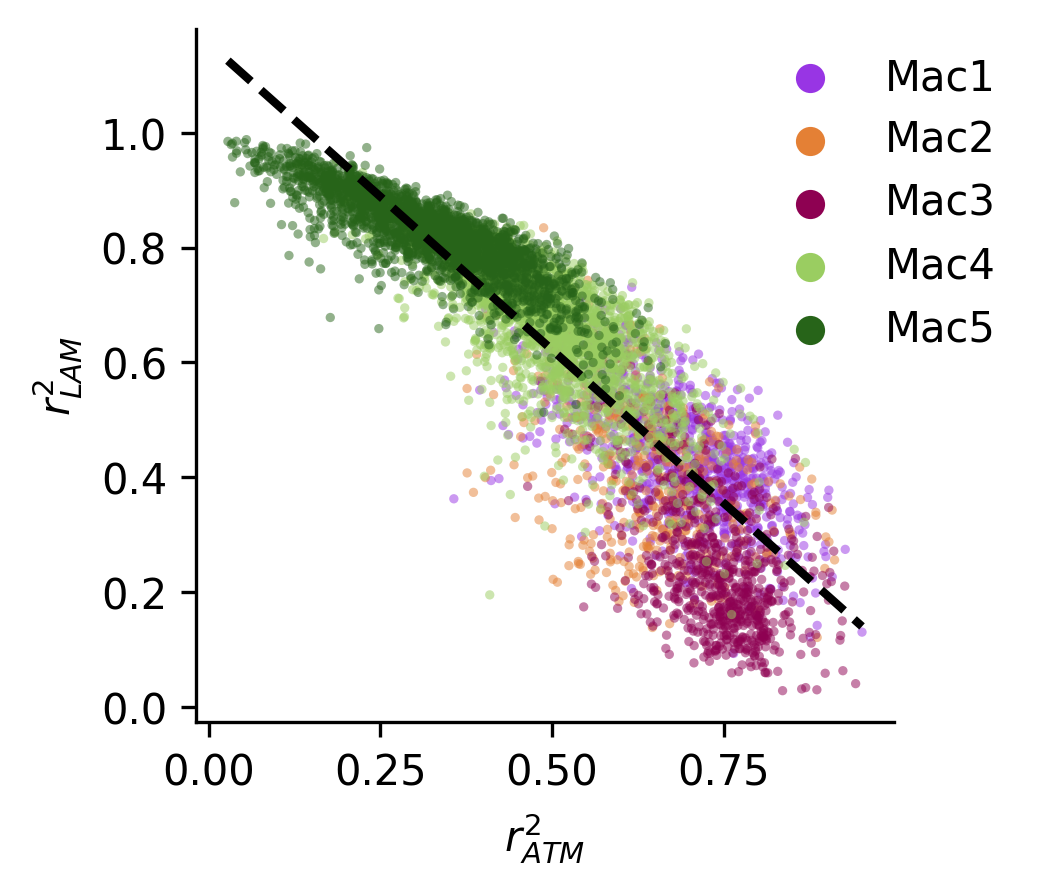

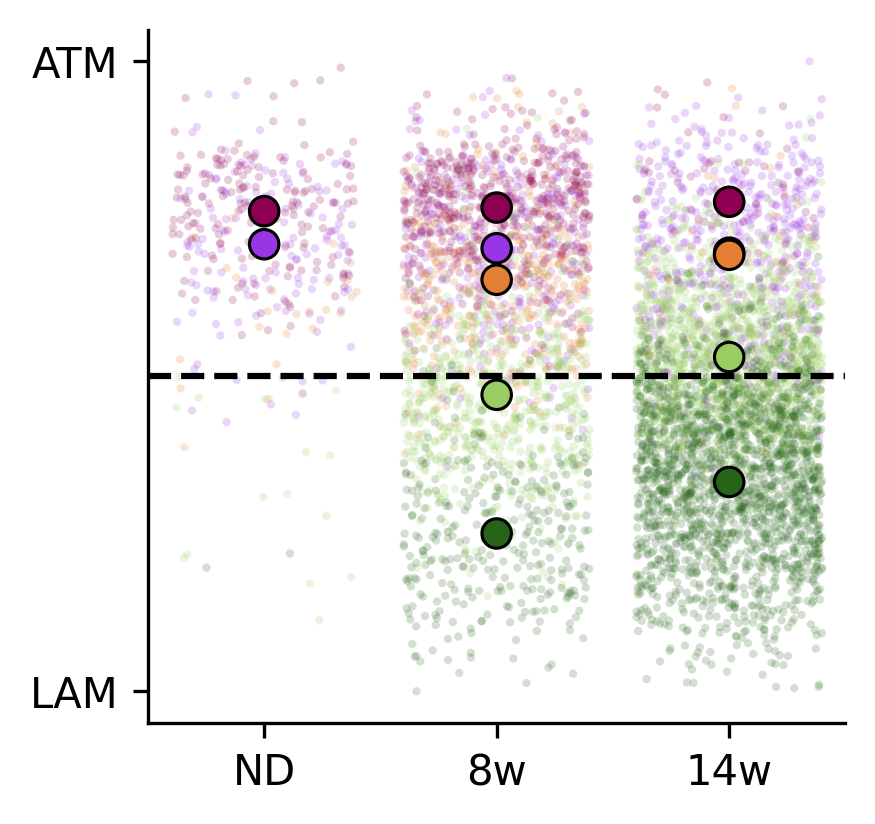

In [18]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

# remove outliers before fitting models
lb = 0.001
ub = 0.999
pdf = cont.filterPoints(pdf, lb, ub)

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)


# get linear projection
pdf = cont.getProjection(pdf)


## define colors
colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]

colMap = dict(zip(macTypes, colors))
pdf['color'] = pdf['cellType'].map(colMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=pdf, 
                x='p1',
                y='p2',
                hue='cellType',
                palette=colors,
                s=5,
                alpha=0.5,
                ec='None')

sns.lineplot(data=pdf,
             x='p1',
             y='fit',
             ls="--",
             lw=2,
             color='k')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.2, 1.015),
                frameon=False,
                title="")

plt.ylabel(r"$r^2_{LAM}$")
plt.xlabel(r"$r^2_{ATM}$")

plt.show()

plt.show()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"


""" great grouped means plot """
means = pdf.groupby(['keyName', 'cellType']).agg(
    dists = ('dists', 'mean'),
    nCells = ('dists', 'count'),
).reset_index(drop=False)

means['color'] = means['cellType'].map(colMap)

# threshold small groups
t = 30
means = means[means['nCells'] > t]

means = means.sort_values(by='keyName', ascending=False)


sns.scatterplot(data=means, 
                x='keyName',
                y='dists',
                c=means['color'].to_list(),
                s=50,
                ec='k',
                linewidth=0.75,
                zorder=5)

sns.stripplot(data=pdf, 
                y='dists',
                x='keyName',
                hue='cellType',
                jitter=0.4,
                s=2,
                palette=colors,
                alpha=0.2)

plt.axhline(y = 0.5, c='k', ls='--', zorder=3)
sns.despine()
plt.gca().legend().remove()


plt.xlabel("")
plt.ylabel("")
plt.yticks([pdf['dists'].min(), pdf['dists'].max()], ['LAM', 'ATM'])

plt.show()

In [19]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "m0_m2_macspectrum.csv"
pdf.to_csv(f"{dirpath}{fname}", index=False)
pdf.head()

p1        p2              cellId key cellType         x         y   
0  0.680100  0.420121  AAAGAACGTCTACAGT.1  ND     Mac1  3.089298 -1.726030  \
1  0.683606  0.482199  AAAGAACTCCTCGCAT.1  ND     Mac1  3.614130 -1.571004   
2  0.627450  0.663126  AACAAAGGTTCACGAT.1  ND     Mac1  0.130051 -1.583494   
3  0.787689  0.171188  AACAGGGAGCTGAAGC.1  ND     Mac1  3.194319 -2.195499   
4  0.666395  0.474536  AAGAACAAGACTCATC.1  ND     Mac1  2.172548  0.995615   

     metaTypes keyName       fit        xp        yp         l  p2_on_fit   
0  Macrophages      ND  0.429780  0.964187 -0.031790  0.952065   0.429780  \
1  Macrophages      ND  0.426040  0.922892 -0.080766  0.921958   0.426040   
2  Macrophages      ND  0.485942  0.758832 -0.176886  0.796782   0.485942   
3  Macrophages      ND  0.315011  1.209883  0.079158  1.183711   0.315011   
4  Macrophages      ND  0.444398  0.916942 -0.062936  0.912052   0.444398   

      dists    color  
0  0.705939  #9835e4  
1  0.709733  #9835e4  
2  0.648966  #9835e4  
3  0.822363  #9835e4  
4  0.691109  #9835e4

In [ ]:
# break

# MN-LAM Polarization

In [20]:
mon = []

for key in ['ND', 'HFD8']:
    mf = cont.getGroup(rna, labels, key, 'Monocytes')
    mon.append(mf)
    
p1 = pd.concat(mon)    
p2 = cont.getGroup(rna, labels, 'HFD14', 'Mac5')

print(f"{p1.shape=} {p2.shape=}")


# get the differnetially expressed genes
deg = cont.getDEGs(p1, p2)

alpha = 0.01
n = 200 # number of genes 
p = None

corrGenes, sig = cont.getSignificant(deg, alpha, n, p, method='log2foldchange')
print(f"{sig.shape=}")

p1.shape=(889, 31053) p2.shape=(1870, 31053)
alpha=0.01 ntests=31053 3.2365099111864026e-07
sig.shape=(200, 9)


In [21]:
macTypes = ['Mac1','Mac2','Mac3','Mac4','Mac5', 'Monocytes']

res = []

normalize = True
log = True
metric = 'correlation'

# build the signature of the poles
meanP1 = cont.getSignature(p1, corrGenes, norm=normalize, log=log)
meanP2 = cont.getSignature(p2, corrGenes, norm=normalize, log=log)

print(f"{meanP1.shape=} {meanP2.shape=}")

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # get correlations to cell type
    rf = rf[corrGenes]
    rf = rf.fillna(0)
    
    if log:
        rf = np.log1p(rf)
    
    if normalize:
        rf[corrGenes] = sklearn.preprocessing.minmax_scale(rf[corrGenes], 
                                                           feature_range=(0, 1), axis=1)
        
    p1Dist = scipy.spatial.distance.cdist(rf, meanP1, metric)
    p2Dist = scipy.spatial.distance.cdist(rf, meanP2, metric)
    
    # normalize distance to range (0, 1)
    p1Dist = sklearn.preprocessing.minmax_scale(p1Dist, feature_range=(0, 1))
    p2Dist = sklearn.preprocessing.minmax_scale(p2Dist, feature_range=(0, 1))
    
    pred = pd.DataFrame({
        'p1' : p1Dist.ravel(),
        'p2' : p2Dist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)

res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()

meanP1.shape=(1, 200) meanP2.shape=(1, 200)
res.shape=(8329, 8)


p1        p2              cellId key   cellType         x         y   
0  0.738901  0.269120  AAAGAACGTCTACAGT.1  ND       Mac1  3.089298 -1.726030  \
1  0.761424  0.243256  AAAGAACTCCTCGCAT.1  ND       Mac1  3.614130 -1.571004   
2  0.294081  0.690997  AAAGGGCGTTAGGGTG.1  ND       Mac3  3.086352  6.166065   
3  0.279340  0.735821  AACAAAGAGTATAGGT.1  ND  Monocytes  3.178745  4.929769   
4  0.278696  0.715537  AACAAAGCACCGGCTA.1  ND       Mac3  4.344001  5.801922   

     metaTypes  
0  Macrophages  
1  Macrophages  
2  Macrophages  
3    Monocytes  
4  Macrophages

x = p1, y = p2
1.0684x + y + -1.1694 = 0


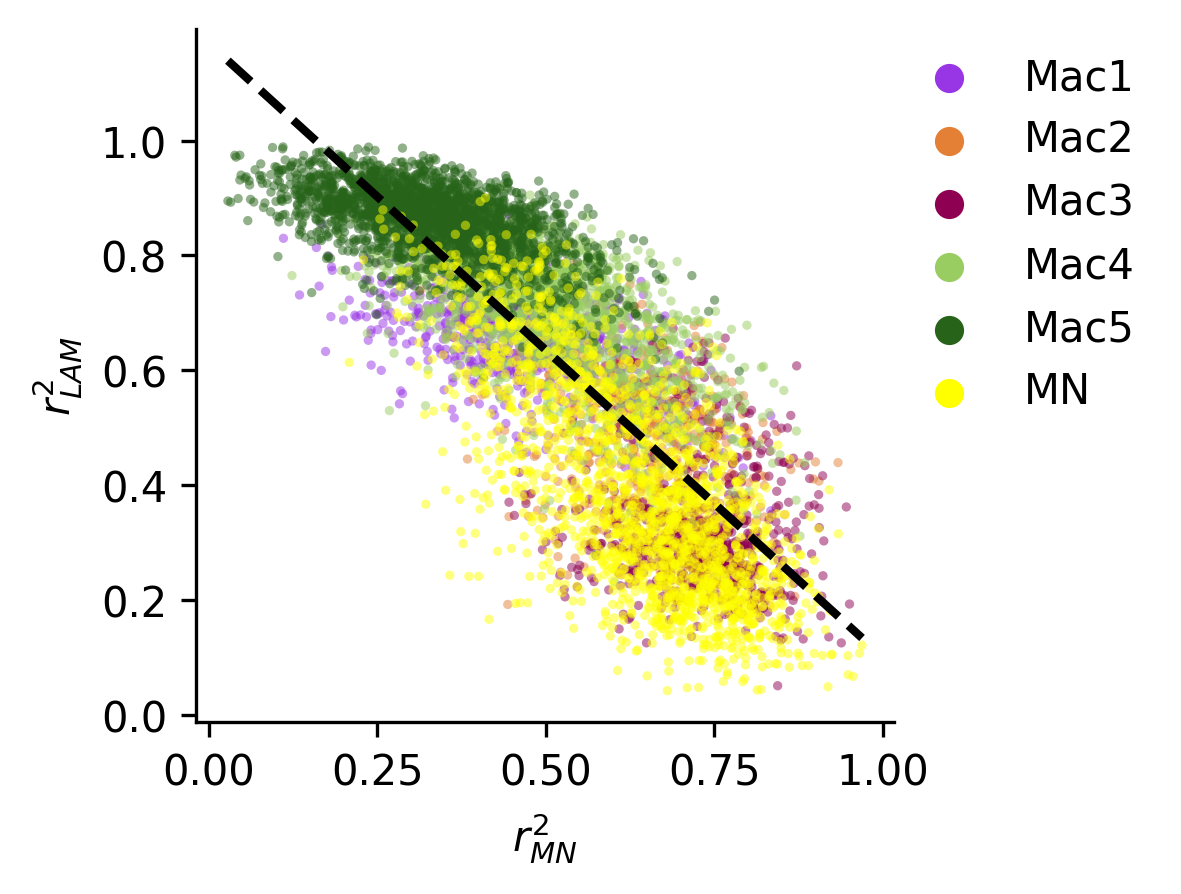

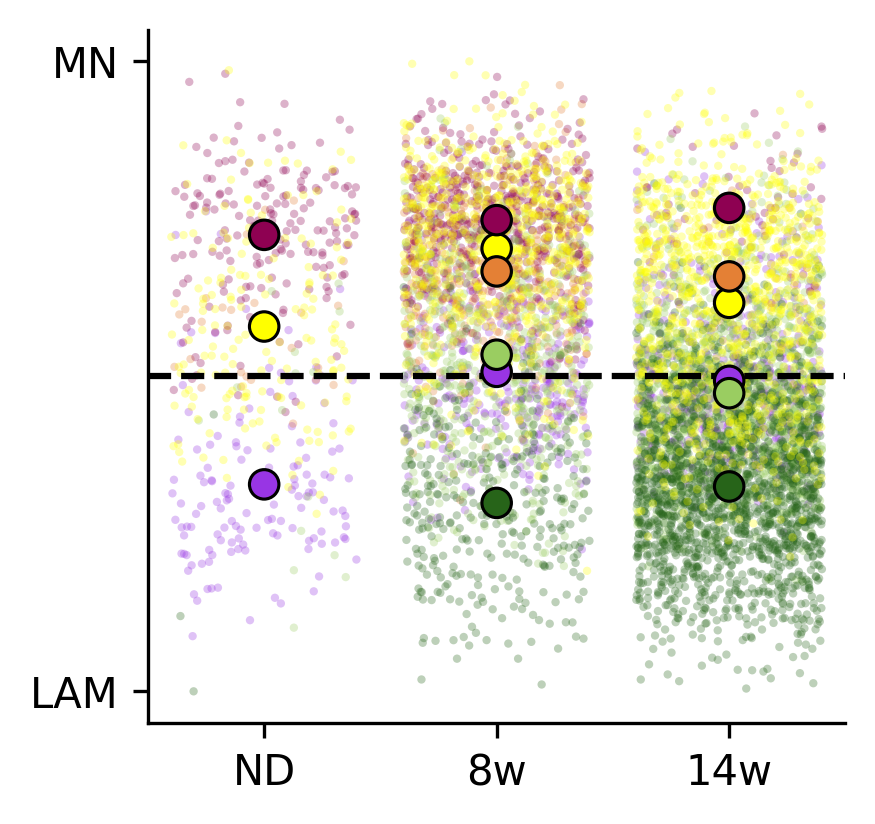

In [22]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

pdf['cellType'] = np.where(pdf['cellType'] == 'Monocytes', "MN", pdf['cellType'])

# remove outliers before fitting models
lb = 0.001
ub = 0.999
pdf = cont.filterPoints(pdf, lb, ub)

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)


# get linear projection
pdf = cont.getProjection(pdf)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=pdf, 
                x='p1',
                y='p2',
                hue='cellType',
                palette=colors,
                s=5,
                alpha=0.5,
                ec='None')

sns.lineplot(data=pdf,
             x='p1',
             y='fit',
             ls="--",
             lw=2,
             color='k')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1.015),
                frameon=False,
                title="")

plt.ylabel(r"$r^2_{LAM}$")
plt.xlabel(r"$r^2_{MN}$")

plt.show()

plt.show()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

""" great grouped means plot """
means = pdf.groupby(['keyName', 'cellType']).agg(
    dists = ('dists', 'mean'),
    nCells = ('dists', 'count'),
).reset_index(drop=False)

means['color'] = means['cellType'].map(colMap)

# threshold small groups
t = 30
means = means[means['nCells'] > t]

means = means.sort_values(by='keyName', ascending=False)


sns.scatterplot(data=means, 
                x='keyName',
                y='dists',
                c=means['color'].to_list(),
                s=50,
                ec='k',
                linewidth=0.75,
                zorder=5)

sns.stripplot(data=pdf, 
                y='dists',
                x='keyName',
                hue='cellType',
                jitter=0.4,
                s=2,
                palette=colors,
                alpha=0.3)


plt.axhline(y = 0.5, c='k', ls='--', zorder=3)
sns.despine()
plt.gca().legend().remove()


plt.xlabel("")
plt.ylabel("")
plt.yticks([pdf['dists'].min(), pdf['dists'].max()], ['LAM', 'MN'])

plt.show()

In [23]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "mn_lam_macspectrum.csv"
pdf.to_csv(f"{dirpath}{fname}", index=False)
pdf.head()

p1        p2              cellId key cellType         x         y   
0  0.261099  0.730880  AAAGAACGTCTACAGT.1  ND     Mac1  3.089298 -1.726030  \
1  0.238576  0.756744  AAAGAACTCCTCGCAT.1  ND     Mac1  3.614130 -1.571004   
2  0.159480  0.813876  AACAAAGGTTCACGAT.1  ND     Mac1  0.130051 -1.583494   
3  0.409659  0.559722  AACAGGGAGCTGAAGC.1  ND     Mac1  3.194319 -2.195499   
4  0.492853  0.692619  AAGAACAAGACTCATC.1  ND     Mac1  2.172548  0.995615   

     metaTypes keyName       fit        xp        yp         l  p2_on_fit   
0  Macrophages      ND  0.890469  0.467395  0.035969  0.450016   0.890469  \
1  Macrophages      ND  0.914533  0.435266  0.032472  0.419546   0.914533   
2  Macrophages      ND  0.999041  0.345499  0.044829  0.329595   0.999041   
3  Macrophages      ND  0.731744  0.679698  0.059450  0.655783   0.731744   
4  Macrophages      ND  0.642858  0.642035 -0.094665  0.655031   0.642858   

      dists    color  
0  0.247521  #9835e4  
1  0.223589  #9835e4  
2  0.139547  #9835e4  
3  0.405371  #9835e4  
4  0.493768  #9835e4

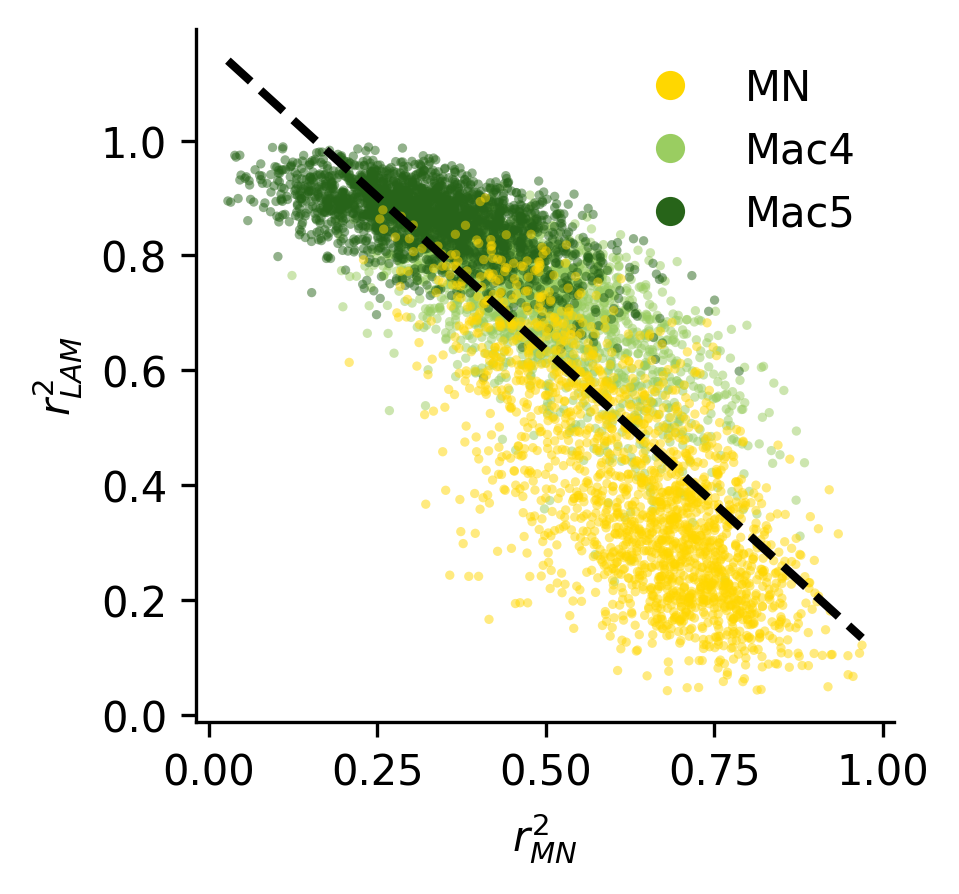

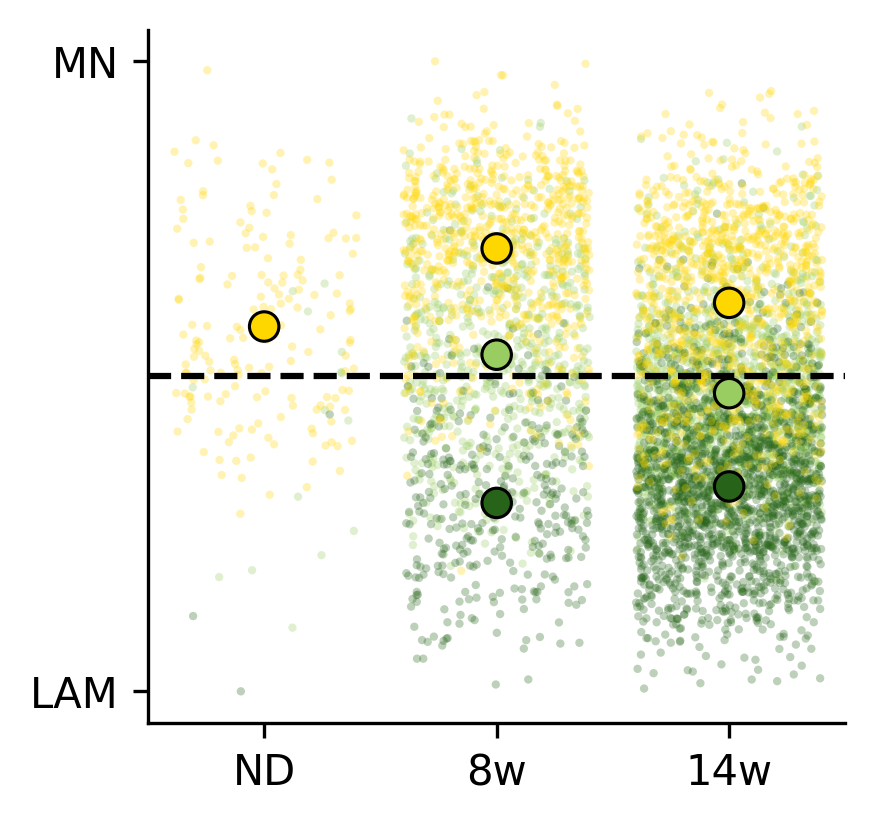

In [24]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"


keepers = ['MN', 'Mac4', 'Mac5']

pdf = pdf[pdf['cellType'].isin(keepers)]
means = means[means['cellType'].isin(keepers)]

repColor = 'gold'

pdf['color'] = np.where(pdf['color'] == mncolor, repColor, pdf['color'])
means['color'] = np.where(means['color'] == mncolor, repColor, means['color'])

sns.scatterplot(data=pdf, 
                x='p1',
                y='p2',
                c=pdf['color'].to_list(),
                s=5,
                alpha=0.5,
                ec='None')

sns.lineplot(data=pdf,
             x='p1',
             y='fit',
             ls="--",
             lw=2,
             color='k')

sns.despine()

handles = []
pltlabels = []

for idx, row in means[['cellType', 'color']].drop_duplicates().iterrows():
    pltlabels.append(row['cellType'])
    handles.append(Line2D([], [], 
                          marker='o',
                          color=row['color'], 
                          linestyle='None'))

plt.legend(handles, pltlabels, loc='upper right', frameon=False)

plt.ylabel(r"$r^2_{LAM}$")
plt.xlabel(r"$r^2_{MN}$")

plt.show()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=means, 
                x='keyName',
                y='dists',
                c=means['color'].to_list(),
                s=50,
                ec='k',
                linewidth=0.75,
                zorder=5)

sns.stripplot(data=pdf, 
                y='dists',
                x='keyName',
                hue='cellType',
                jitter=0.4,
                s=2,
                palette=['#9acd61', '#276419', repColor],
                alpha=0.3)


plt.axhline(y = 0.5, c='k', ls='--', zorder=3)
sns.despine()
plt.gca().legend().remove()


plt.xlabel("")
plt.ylabel("")
plt.yticks([pdf['dists'].min(), pdf['dists'].max()], ['LAM', 'MN'])

plt.show()

# All Together!

In [ ]:
""" Monocyte """
m1 = cont.getGroup(rna, labels, 'ND', 'Monocytes')
m2 = cont.getGroup(rna, labels, 'HFD8', 'Monocytes')
p1 = pd.concat([m1, m2])    

""" resident ATM """
m1 = cont.getGroup(rna, labels, 'ND', 'Mac1') # pole 1 is ATM
# m2 = cont.getGroup(rna, labels, 'HFD8', 'Mac1') 
# m3 = cont.getGroup(rna, labels, 'HFD14', 'Mac1') 
m2 = cont.getGroup(rna, labels, 'ND', 'Mac2') # pole 1 is ATM
# m3 = cont.getGroup(rna, labels, 'ND', 'Mac3') # pole 1 is ATM

p2 = pd.concat([m1, m2, m3], ignore_index=True)

""" LAM """
p3 = cont.getGroup(rna, labels, 'HFD14', 'Mac5')

print(f"{p1.shape=} {p2.shape=} {p3.shape=}")

In [ ]:
""" Get DEGs. Note: do we need to perform DE against all other cells, not just a single group? """
pairs  = [
    (p1, pd.concat([p2, p3])),
    (p2, pd.concat([p1, p3])),
    (p3, pd.concat([p1, p2])),
]

geneDupTresh = 2 # only genes counted < this will be considered
alpha = 0.01
n = 50 # number of genes 

corrGenes = []

for px, py in pairs:
    # get the differnetially expressed genes
    deg = cont.getDEGs(px, py)
    genes, sig = cont.getSignificant(deg, alpha, n, p, method='log2foldchange')
    corrGenes += genes
    
    
""" remove genes that appear in multiple cell type DEGs """
print(f"{len(corrGenes)=} (all) {len(set(corrGenes))=} (unique)")
counts = Counter(corrGenes)
corrGenes = [k for k, v in counts.items() if v < geneDupTresh]
print(f"{len(corrGenes)=} (retained) ")
print('done')

In [ ]:
macTypes = ['Mac1','Mac2','Mac3','Mac4','Mac5', 'Monocytes']

res = []

normalize = True
log = True
metric = 'correlation'

# build the signature of the poles
meanP1 = cont.getSignature(p1, corrGenes, norm=normalize, log=log)
meanP2 = cont.getSignature(p2, corrGenes, norm=normalize, log=log)
meanP3 = cont.getSignature(p3, corrGenes, norm=normalize, log=log)


for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # get correlations to cell type
    rf = rf[corrGenes]
    rf = rf.fillna(0)
    
    if log:
        rf = np.log1p(rf)
    
    if normalize:
        rf[corrGenes] = sklearn.preprocessing.minmax_scale(rf[corrGenes], 
                                                           feature_range=(0, 1), axis=1)
        
    p1Dist = scipy.spatial.distance.cdist(rf, meanP1, metric)
    p2Dist = scipy.spatial.distance.cdist(rf, meanP2, metric)
    p3Dist = scipy.spatial.distance.cdist(rf, meanP3, metric)
    
    # normalize distance to range (0, 1)
    p1Dist = sklearn.preprocessing.minmax_scale(p1Dist, feature_range=(0, 1))
    p2Dist = sklearn.preprocessing.minmax_scale(p2Dist, feature_range=(0, 1))
    p3Dist = sklearn.preprocessing.minmax_scale(p3Dist, feature_range=(0, 1))
    
    pred = pd.DataFrame({
        'p1' : p1Dist.ravel(),
        'p2' : p2Dist.ravel(),
        'p3' : p3Dist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)

res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()

In [ ]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

pdf['cellType'] = np.where(pdf['cellType'] == 'Monocytes', "MN", pdf['cellType'])

# remove outliers before fitting models
lb = 0.001
ub = 0.999
pdf = cont.filterPoints(pdf, lb, ub)

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

pdf = pdf[pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5', "MN"])]

pdf.head()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['figure.facecolor'] = "w"

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pdf['p1'], 
           pdf['p2'],
           pdf['p3'], 
           c=pdf['color'], 
           # ec='None',
           ec='k',
           s=40,
           alpha=0.5,
           lw=0.1,
           marker=".")

ax.set_xlabel("Monocyte Similarity", labelpad=10)
ax.set_ylabel("Resident ATM Similarity", labelpad=10)
ax.set_zlabel("LAM Similarity", labelpad=10)

ax.set_xlim([0, 1])
ax.set_ylim([1, 0])
ax.set_zlim([0, 1])

# ax.view_init(elev=30, azim=70)
ax.view_init(azim=-20)
ax.dist = 13

In [ ]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 3, 3
# plt.rcParams['figure.facecolor'] = "w"

# sns.kdeplot(data=pdf, 
#             x='p2',
#             y='p3',
#             shade=True,
#             hue='key',
#             palette='viridis', 
#             alpha=0.5)

In [ ]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

pdf['cellType'] = np.where(pdf['cellType'] == 'Monocytes', "MN", pdf['cellType'])

# remove outliers before fitting models
lb = 0.001
ub = 0.999
pdf = cont.filterPoints(pdf, lb, ub)

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

pdf = pdf[pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5', "MN"])]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['figure.facecolor'] = "w"

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


for i, key in enumerate(keys):
    mask = (pdf['key'] == key)
    cx = pdf[mask]
    
    ax.scatter(cx['p2'], 
               [i]*len(cx), 
               cx['p3'],
               c=cx['color'], 
               # ec='None',
               ec='k',
               s=30,
               alpha=0.5,
               lw=0.1,
               marker=".")
    
ax.set_yticks([0, 1, 2], ['ND', '8w', '14w'])
ax.set_xlabel("rATM Similarity", labelpad=10)
ax.set_ylabel("")
ax.set_zlabel("LAM Similarity", labelpad=10)

ax.dist = 13

In [ ]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

pdf['cellType'] = np.where(pdf['cellType'] == 'Monocytes', "MN", pdf['cellType'])

# remove outliers before fitting models
lb = 0.001
ub = 0.999
pdf = cont.filterPoints(pdf, lb, ub)

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

pdf = pdf[pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5', "MN"])]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 18, 6
plt.rcParams['figure.facecolor'] = "w"

fig = plt.figure()

for i, key in enumerate(keys):
    mask = (pdf['key'] == key)
    cx = pdf[mask]
    
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    ax.scatter(cx['p1'], 
               cx['p2'],
               cx['p3'], 
               c=cx['color'], 
               ec='k',
               # ec='None',
               s=50,
               alpha=1,
               zorder=5,
               lw=0.4,
               marker=".")

    # ax.set_title(keyMap[key])
    # ax.set_xlabel("Monocyte Similarity", labelpad=10)
    # ax.set_ylabel("Resident ATM Similarity", labelpad=10)
    # ax.set_zlabel("LAM Similarity", labelpad=10)
    
    ticks = np.linspace(0, 1, 7)
    tickLabels = [f"{x:.1f}" for x in ticks]
    
    ax.set_xticks(ticks, tickLabels)
    ax.set_yticks(ticks, tickLabels)
    ax.set_zticks(ticks, tickLabels)

    
    ax.set_xlim([0, 1])
    ax.set_ylim([1, 0])
    ax.set_zlim([0, 1])
    
    ax.view_init(azim=-20)
    ax.dist = 11

    # ax.view_init(elev=15, azim=75)
    
# plt.tight_layout()
plt.subplots_adjust(wspace=0)

In [ ]:
break

In [ ]:
def drawSphere(xCenter, yCenter, zCenter, rx, ry, rz):
    #draw sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    # shift and scale sphere
    x = (rx * x) + xCenter
    y = (ry * y) + yCenter
    z = (rz * z) + zCenter
    return (x,y,z)

In [ ]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

pdf['cellType'] = np.where(pdf['cellType'] == 'Monocytes', "MN", pdf['cellType'])

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 18, 6
plt.rcParams['figure.facecolor'] = "w"

fig = plt.figure()

for i, key in enumerate(keys):
    mask = (pdf['key'] == key)
    cx = pdf[mask]
    
    gx = cx.groupby(['cellType', 'color']).agg(
        n = ('p1', 'count'),
        xp1 = ('p1', 'mean'),
        rp1 = ('p1', 'std'),
        xp2 = ('p2', 'mean'),
        rp2 = ('p2', 'std'),
        xp3 = ('p3', 'mean'),
        rp3 = ('p3', 'std'),
        
    ).reset_index(drop=False)
    
    ax = fig.add_subplot(1, 3, i+1, projection='3d')  
    
    # ax.scatter(cx['p1'], 
    #        cx['p2'],
    #        cx['p3'], 
    #        c=cx['color'], 
    #        ec='k',
    #        s=50,
    #        alpha=1,
    #        zorder=1,
    #        lw=0.4,
    #        marker=".")
    
    
    for idx, row in gx.iterrows():
        if row['n'] > 40:
            
            sf = 2
            (xs,ys,zs) = drawSphere(row['xp1'], 
                                    row['xp2'], 
                                    row['xp3'], 
                                    row['rp1'] * sf,
                                    row['rp2'] * sf,
                                    row['rp3'] * sf)

            ax.plot_surface(xs, 
                            ys, 
                            zs,
                            rstride=1,
                            cstride=1,
                            alpha=0.4,
                            zorder=2,
                            color=row['color'],
                            shade=True,)
        
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])

    ax.set_title(keyMap[key])
    ax.set_xlabel(r"$r^2_{MN}$")
    ax.set_ylabel(r"$r^2_{ATM}$")
    ax.set_zlabel(r"$r^2_{LAM}$")

    ax.view_init(elev=50, azim=80)
    
# plt.tight_layout()

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# drop nan correlations
pdf = pdf[pdf['p1'].notna()]
pdf = pdf[pdf['p2'].notna()]
pdf = pdf[pdf['p3'].notna()]


# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 15
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(3, 2)
axs = axs.ravel()


for i, ctype in enumerate(sorted(pdf['cellType'].unique())):
    
    cx = pdf[pdf['cellType'] == ctype].reset_index()
    cx = cx.sort_values(by='key', ascending=False,)
    print(ctype, cx.shape)
    
    # plot p1
    sns.kdeplot(data=cx,
                x='p1',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=axs[i])

    axs[i].set_title(ctype)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_ylabel("MN", rotation=0, labelpad=10)
    axs[i].set_xlabel("")
    
    # set up second axis
    ax_divider = make_axes_locatable(axs[i])
    
    # plot p2
    ax2 = ax_divider.append_axes("bottom", 
                                 size="100%", 
                                 pad=f"25%")
    
    sns.kdeplot(data=cx,
                x='p2',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=ax2)
    
    ax2.sharex(axs[i])
    ax2.set_ylabel("ATM", rotation=0, labelpad=10)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_xlabel("")
    
    
    ax3 = ax_divider.append_axes("bottom", 
                                 size="100%", 
                                 pad=f"25%")
    
    sns.kdeplot(data=cx,
                x='p3',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=ax3)
    
    ax3.sharex(axs[i])
    ax3.set_ylabel("LAM", rotation=0, labelpad=10)
    ax3.set_yticks([])
    
    # format x axis
    ax3.set_xlabel("Correlation")
    # axs[i].set_xticks([0, 0.5, 1])
    axs[i].set_xlim([0, 1.1])

   
    
    # break
    
sns.despine()
plt.tight_layout()

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# drop nan correlations
pdf = pdf[pdf['p1'].notna()]
pdf = pdf[pdf['p2'].notna()]
pdf = pdf[pdf['p3'].notna()]


# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 15
plt.rcParams['figure.facecolor'] = "w"

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 7
plt.rcParams['figure.facecolor'] = "w"
fig, axs = plt.subplots(3, 1)
axs = axs.ravel()

pdf = pdf[pdf['cellType'].isin(['Mac4', 'Mac5', 'Monocytes'])]


for i, ctype in enumerate(sorted(pdf['cellType'].unique())):
    
    cx = pdf[pdf['cellType'] == ctype].reset_index()
    cx = cx.sort_values(by='key', ascending=False,)
    print(ctype, cx.shape)
    
    # plot p1
    sns.kdeplot(data=cx,
                x='p1',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=axs[i])

    axs[i].set_title(ctype)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_ylabel("MN", rotation=0, labelpad=10)
    axs[i].set_xlabel("")
    
    # set up second axis
    ax_divider = make_axes_locatable(axs[i])
    
    # plot p2
    ax2 = ax_divider.append_axes("bottom", 
                                 size="100%", 
                                 pad=f"25%")
    
    sns.kdeplot(data=cx,
                x='p2',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=ax2)
    
    ax2.sharex(axs[i])
    ax2.set_ylabel("ATM", rotation=0, labelpad=10)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_xlabel("")
    
    
    ax3 = ax_divider.append_axes("bottom", 
                                 size="100%", 
                                 pad=f"25%")
    
    sns.kdeplot(data=cx,
                x='p3',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=ax3)
    
    ax3.sharex(axs[i])
    ax3.set_ylabel("LAM", rotation=0, labelpad=10)
    ax3.set_yticks([])
    
    # format x axis
    ax3.set_xlabel("Correlation")
    # axs[i].set_xticks([0, 0.5, 1])
    axs[i].set_xlim([0, 1.1])

   
    
    # break
    
sns.despine()
plt.tight_layout()

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# drop nan correlations
pdf = pdf[pdf['p1'].notna()]
pdf = pdf[pdf['p2'].notna()]
pdf = pdf[pdf['p3'].notna()]


# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, True])
pdf = pdf.reset_index(drop=True)


metric = 'euclidean'
dist = metrics.pairwise_distances(pdf[['p1', 'p2', 'p3']], 
                                  metric=metric)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = "w"

cmap = plt.cm.get_cmap('plasma', lut=8)
# cmColors = ["lightgrey", "orangered"]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cmColors)

plt.imshow(dist, cmap=cmap)

lines = pdf[pdf['cellType'].astype('category').cat.codes.diff() != 0].index.tolist()
for l in lines:
    plt.axvline(x=l, c='k', lw=1)
    plt.axhline(y=l, c='k', lw=1)
    
# set up ticks 
ticks = lines.copy()
ticks.append(len(pdf))
ticks = [np.sum(ticks[i:i+2])//2 for i in range(len(ticks)-1)]
tickLabels = pdf['cellType'].unique()

_ = plt.xticks(ticks, tickLabels, rotation=90)
_ = plt.yticks(ticks, tickLabels)

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# drop nan correlations
pdf = pdf[pdf['p1'].notna()]
pdf = pdf[pdf['p2'].notna()]
pdf = pdf[pdf['p3'].notna()]


# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

for pi, key in enumerate(keys):
    cx = pdf[pdf['key'] == key]
    cx = cx.sort_values(by='cellType', ascending=True)
    cx = cx.reset_index(drop=True)


    metric = 'euclidean'
    dist = metrics.pairwise_distances(cx[['p1', 'p2', 'p3']], 
                                      metric=metric)



    # get square ranges
    blocks = cx[cx['cellType'].astype('category').cat.codes.diff() != 0].index.tolist()
    blocks.append(len(cx))
    blocks = [blocks[i:i+2] for i in range(len(blocks)-1)]

    A = np.zeros((6, 6))

    for i, ib in enumerate(blocks):
        for j, jb in enumerate(blocks):

            win = dist[ib[0]:ib[1], jb[0]:jb[1]]
            # A[i, j] = np.median(win)
            A[i, j] = np.mean(win)
            # A[i, j] = np.std(win)

    A = pd.DataFrame(A)

    # get the upper triagle mask
    mask = np.zeros_like(A, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False


    A.index = cx['cellType'].unique()
    A.columns = cx['cellType'].unique()

    sns.heatmap(data=A,
                # linewidth=0.5,
                # linecolor='k',
                vmin=0, 
                vmax=1,
                annot=True, 
                mask=mask,
                square=True,
                cbar=False,
                # annot_kws={'rotation': 45},
                fmt=".2f",
                cmap='magma',
                ax=axs[pi]
                )

    axs[pi].tick_params(axis='y', rotation=0)
    axs[pi].set_title(keyMap[key])

sns.despine(top=True, 
            right=True, 
            left=True, 
            bottom=True)
    
plt.tight_layout()

In [ ]:
dist.shape

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6.5, 5
plt.rcParams['figure.facecolor'] = "w"
fig, axs = plt.subplots(3, 2)
axs = axs.ravel()

for i, ctype in enumerate(sorted(pdf['cellType'].unique())):
    
    cx = pdf[pdf['cellType'] == ctype].reset_index()
    
    # # filter out cells with low counts
    # cx['nTime'] = cx.groupby('key')['cellId'].transform('count')
    # cx = cx[cx['nTime'] > 100]
    
    cx = pd.melt(cx, 
                 id_vars=['keyName'],
                 value_vars=['p1', 'p2', 'p3'])
    
    sns.stripplot(data=cx, 
                x='keyName',
                y='value',
                # showfliers=False,
                s=2,
                alpha=0.2,
                dodge=True,
                zorder=2,
                hue='variable',
                palette=['yellow', '#9835e4', '#276419'],
                ax=axs[i])
    
    axs[i].axhline(y=0.5, 
                   lw=0.75, 
                   c='k', 
                   zorder=1)
    axs[i].set_title(ctype)
    axs[i].set_ylabel("Correlation")
    axs[i].set_xlabel("")
    axs[i].legend().remove()
    axs[i].set_ylim([0, 1])
    
    print(i, ctype)
    print(cx.head())

    
    # break


sns.despine()
plt.tight_layout()

In [ ]:
# pdf = res.copy()

# # convert distances to correlations
# pdf['p1'] = 1 - pdf['p1']
# pdf['p2'] = 1 - pdf['p2']
# pdf['p3'] = 1 - pdf['p3']

# # rename time points
# keyMap = {
#     "ND" : "ND",
#     "HFD8" : "8w",
#     "HFD14" : "14w",
# }
# pdf['keyName'] = pdf['key'].map(keyMap)

# mncolor = 'yellow'

# colors = [
#     '#9835e4',
#     '#e48035',
#     '#8e0152',
#     '#9acd61',
#     '#276419',
#     mncolor,
# ]

# colMap = dict(zip(macTypes, colors))
# colMap['MN'] = mncolor
# pdf['color'] = pdf['cellType'].map(colMap)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6.5, 5
# plt.rcParams['figure.facecolor'] = "w"
# fig, axs = plt.subplots(3, 2)
# axs = axs.ravel()

# for i, ctype in enumerate(sorted(pdf['cellType'].unique())):
    
#     cx = pdf[pdf['cellType'] == ctype].reset_index()
    
#     # # filter out cells with low counts
#     # cx['nTime'] = cx.groupby('key')['cellId'].transform('count')
#     # cx = cx[cx['nTime'] > 100]
    
#     cx = pd.melt(cx, 
#                  id_vars=['keyName'],
#                  value_vars=['p1', 'p2', 'p3'])
    
#     sns.boxplot(data=cx, 
#                 x='keyName',
#                 y='value',
#                 showfliers=False,
#                 # s=2,
#                 # alpha=0.2,
#                 # dodge=True,
#                 # zorder=2,
#                 hue='variable',
#                 palette=['yellow', '#9835e4', '#276419'],
#                 ax=axs[i])
    
#     axs[i].axhline(y=0.5, 
#                    lw=0.75, 
#                    c='k', 
#                    zorder=1)
#     axs[i].set_title(ctype)
#     axs[i].set_ylabel("Correlation")
#     axs[i].set_xlabel("")
#     axs[i].legend().remove()
#     axs[i].set_ylim([0, 1])
    
#     print(i, ctype)
#     print(cx.head())

    
#     # break


# sns.despine()
# plt.tight_layout()

In [ ]:


# sns.jointplot(data=pdf, 
#               x="p2", 
#               y="p3", 
#               palette=colors,
#               hue="cellType")

# sns.jointplot(data=pdf, 
#               x='p1', 
#               y='p2',
#               kind="hex", 
#               color="#4CB391")

# sns.lmplot(
#     data=pdf,
#     x="p1", 
#     y="p2", 
#     hue="cellType",
#     palette=colors,
# )

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 18, 6
# plt.rcParams['figure.facecolor'] = "w"

# pdf = pdf.sort_values(by='cellType')

# g = sns.FacetGrid(pdf, 
#                   row="cellType", 
#                   hue="cellType", 
#                   height=1, 
#                   aspect=6,
#                   palette=colors,
#                   # palette='viridis',
#                  )

# # Draw the densities in a few steps
# g.map(sns.kdeplot, 
#       "p3", 
#       # bw_adjust=1, 
#       clip_on=True,
#       fill=True 
#      )


# # g.set_titles("")

# g.set(ylabel="", 
#       xlim=[0, 1],
#       xticks=[0, 1],
#       # xticklabels=['MN', 'LAM']
#      )

In [ ]:
# sys.path.append("/home/cstansbu/.local/lib/python3.7/site-packages/")
# import plotly.express as px
# from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import *
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# init_notebook_mode(connected=True) 


# fig = px.scatter_3d(pdf, 
#                     x='p1', 
#                     y='p2',
#                     z='p3',
#                     labels={
#                       "p1": "Monocyte Correlation",
#                       "p2": "ATM Correlation",
#                       "p3": "LAM Correlation",
#                     },
#                     color='cellType',
#                     color_discrete_sequence=colors,
#                     width=800, 
#                     height=800)

# fig.update_traces(marker=dict(size=5,
#                               line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# fig.write_html("test.html")
# print('done')

In [ ]:
# fig = make_subplots(rows=1, 
#                     cols=3,
#                     specs=[[{'is_3d': True}, 
#                            {'is_3d': True},
#                            {'is_3d': True},]]
#                    )


# for i, key in enumerate(keys):
#     mask = (pdf['key'] == key)
#     cx = pdf[mask]
    
#     fig.add_trace(go.Scatter3d(x=cx['p1'], 
#                                y=cx['p2'],  
#                                z=cx['p3'],
#                                mode='markers',
#                                marker=dict(
#                                    size=5,
#                                    color=cx['color'],
#                                    line_width=1)
#                               ),
#                 row=1, 
#                 col=i+1,
#             )

    
#     break
# fig.show()



In [ ]:
# dir(go.Scatter)